In this section, we’ll attempt to predict the median price of homes

It has relatively few data points: only 506, split between 404 training samples and 102 test samples. And each feature in the input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between 0 and 1, others take values between 1 and 12, others between 0 and 100, and so on.

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = (
	boston_housing.load_data())

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step


he prices are typically between $10,000 and $50,000

It would be problematic to feed into a neural network values that all take wildly different ranges. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice for dealing with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in NumPy

In [2]:
# Normalize the data
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std


Note that the quantities used for normalizing the test data are computed using the training data. You should never use any quantity computed on the test data in your workflow, even for something as simple as data normalization.

In [4]:
import keras
from keras import layers

def build_model():
	model = keras.Sequential([
		layers.Dense(64, activation="relu"),
		layers.Dense(64, activation="relu"),
		layers.Dense(1)
	])
	model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
	return model

The model ends with a single unit and no activation (it will be a linear layer). This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value). Applying an activation function would constrain the range the output can take; for instance, if you applied a sigmoid activation function to the last layer, the model could only learn to predict values between 0 and 1. Here, because the last layer is purely linear, the model is free to learn to predict values in any range. Note that we compile the model with the mse loss function—mean squared error, the square of the difference between the predictions and the targets. This is a widely used loss function for regression problems. We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the absolute value of the difference between the predictions and the targets. For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500 on average.

### usaremos K-fold cross validation

It consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained. In terms of code, this is straightforward.

In [8]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
	print(f"Processing fold #{i}")
	val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] # validação a partir da i-ésima partição
	val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

	partial_train_data = np.concatenate(
		[train_data[:i * num_val_samples],
		train_data[(i + 1) * num_val_samples:]
		], axis=0
	)
	partial_train_targets = np.concatenate(
		[train_targets[:i * num_val_samples],
		train_targets[(i + 1) * num_val_samples:]],
		axis=0
	)

	model = build_model()
	model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=16, verbose=0)
	val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
	all_scores.append(val_mae)

average_mae_history = sum(all_scores) / len(all_scores)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [9]:
all_scores

[1.876124620437622, 2.415435791015625, 2.546570062637329, 2.509714365005493]

In [11]:
np.mean(all_scores)

np.float64(2.3369612097740173)

this case, we’re off by $2,600 on average, which is significant considering that the prices range from $10,000 to $50,000. Let’s try training the model a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, we’ll modify the training loop to save the per-epoch validation score log for each fold

In [12]:
import numpy as np

num_epochs = 500
all_mae_histories = []

for i in range(k):
	print(f"Processing fold #{i}")
	val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] # validação a partir da i-ésima partição
	val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

	partial_train_data = np.concatenate(
		[train_data[:i * num_val_samples],
		train_data[(i + 1) * num_val_samples:]
		], axis=0
	)
	partial_train_targets = np.concatenate(
		[train_targets[:i * num_val_samples],
		train_targets[(i + 1) * num_val_samples:]],
		axis=0
	)

	model = build_model()
	history = model.fit(partial_train_data, partial_train_targets,
				validation_data=(val_data, val_targets),
	 			epochs=num_epochs, batch_size=16, verbose=0)
	mae_history = history.history["val_mae"]
	all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


We can compuite the average of the per-epoch MAE scores for all folds

In [13]:
average_mae_history = [
	np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

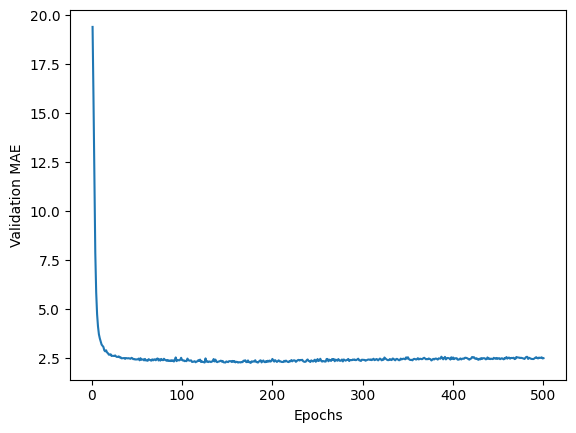

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()




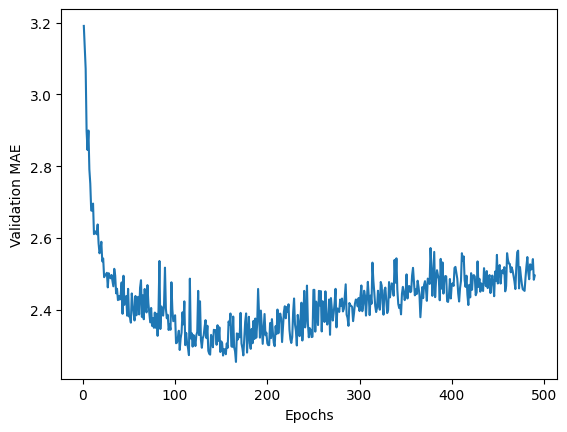

In [15]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()



As you can see in figure 4.10, validation MAE stops improving significantly after 120–140 epochs (this number includes the 10 epochs we omitted). Past that point, we start overfitting. 

Once you’re finished tuning other parameters of the model (in addition to the number of epochs, you could also adjust the size of the intermediate layers), you can train a final production model on all of the training data, with the best parameters, and then look at its performance on the test data.

In [16]:
model = build_model()
model.fit(train_data,train_targets, epochs = 130, batch_size = 16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.3092 - mae: 2.4209


2.4208710193634033

When calling predict() on our binary classification model, we retrieved a scalar score between 0 and 1 for each input sample. With our multiclass classification model, we retrieved a probability distribution over all classes for each sample. Now, with this scalar regression model, predict() returns the model’s guess for the sample’s price in thousands of dollars:

In [21]:
predictions = model.predict(test_data)
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


array([8.747934], dtype=float32)

### Wrapping up

- Regression is done using different loss functions than we used for classification. Mean squared error (MSE) is a loss function commonly used for regression
- Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is mean absolute error (MAE).
- When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
- When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
- When little training data is available, it’s preferable to use a small model with few intermediate layers (typically only one or two), in order to avoid severe overfitting.